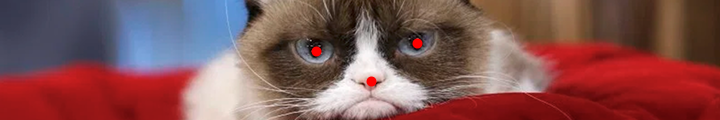

# Introduction

This notebook presents **Keypoint Detection** using a **CNN** on the [CAT](https://www.kaggle.com/crawford/cat-dataset) dataset.

**Resources**

* [Cat Hipsterizer](https://github.com/kairess/cat_hipsterizer) - inspiration for this notebook
* [CAT (Kaggle)](https://www.kaggle.com/crawford/cat-dataset) - dataset used in this notebook
* [CAT (original)](https://archive.org/details/CAT_DATASET) - internet archive link to original data

# Imports

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.ImageDraw

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# Configuration

Point this to dataset directory, folder should contain CAT_00, CAT_01 and so on.

In [3]:
dataset_location = '/home/marcin/Datasets/cat-dataset/cats/'

# Helpers

Helper to draw keypoints on the image

In [4]:
def draw_keypoints(img, keypoints, r=2, c='red'):
    """Draw keypoints on PIL image"""
    draw = PIL.ImageDraw.Draw(img)
    for x, y in keypoints:
        draw.ellipse([x-r, y-r, x+r, y+r], c)
    return img

In [5]:
def plot_images(indices, images, keypoints):
    """Plot bunch of images with keypoint overlay
    
    Params:
        indices - indices of images to plot, e.g. [0, 10, 20, ...]
        images - np.ndarray with raw images, [batch_size, width, height, channel]
        keypoints - np.ndarray with keypoints, [batch_size, num_keypoints, x, y]
    """
    _, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=[12,4])
    if len(indices) == 1: axes = [axes]

    for i, idx in enumerate(indices):
        img = PIL.Image.fromarray(images[idx])
        kps = keypoints[idx]
        axes[i].imshow(draw_keypoints(img, kps))
        axes[i].axis('off')
    
    plt.show()

# Load Dataset

In this section we:

* load images and keypoints from folder structure
* resize to 224x224 and save into numpy .npz file

Subfolders within dataset

In [6]:
folders_all = ['CAT_00', 'CAT_01', 'CAT_02', 'CAT_03', 'CAT_04', 'CAT_05', 'CAT_06']

Get paths to all images

In [7]:
def build_image_files_list(folders):
    image_files_list = []
    for folder in folders:
        wild_path = os.path.join(dataset_location, folder, '*.jpg')
        image_files_list.extend(sorted(glob.glob(wild_path)))
    return image_files_list

In [8]:
image_paths_all = build_image_files_list(folders_all)

In [9]:
print('Nb images:', len(image_paths_all))
image_paths_all[:3]

Nb images: 9997


['/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_000.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_005.jpg',
 '/home/marcin/Datasets/cat-dataset/cats/CAT_00/00000001_008.jpg']

Helper to load keypoint data from *.cat* files

In [10]:
def load_keypoints(path):    
    """Load keypoints from .cat file
    
    The .cat file is a single-line text file in format: 'nb_keypoints x1, y1, x2, y2, ...'
    """
    with open(path, 'r') as f:
        line = f.read().split()  # [nb_keypoints, x1, y1, x2, y2, ...]
    keypoints_nb = int(line[0])  # int
    keypoints_1d = np.array(line[1:], dtype=int)  # np.ndarray, [x1, y1, x2, y2, ...]
    keypoints_xy = keypoints_1d.reshape((-1, 2))  # np.ndarray, [[x1, y1], [x2, y2], ...]
    assert keypoints_nb == len(keypoints_xy)
    assert keypoints_nb == 9                # always nine keypoints, eyes, nose, two ears
    return keypoints_xy                     # np.ndarray, [[x1, y1], [x2, y2], ...]

Open single image and load corresponding keypoints

In [11]:
example_path = image_paths_all[0]
img = PIL.Image.open(example_path)
kps = load_keypoints(example_path+'.cat')

Show example keypoints

In [12]:
display(kps)

array([[175, 160],
       [239, 162],
       [199, 199],
       [149, 121],
       [137,  78],
       [166,  93],
       [281, 101],
       [312,  96],
       [296, 133]])

Show example image

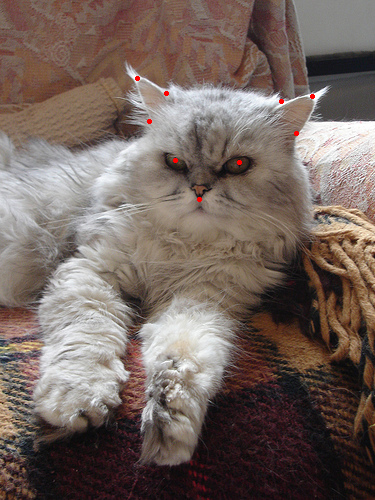

In [13]:
display(draw_keypoints(img.copy(), kps))

Helper to scale image and keypoints

In [14]:
def scale_img_kps(image, keypoints, target_size):
    width, height = image.size
    ratio_w = width / target_size
    ratio_h = height / target_size
    
    image_new = image.resize((target_size, target_size), resample=PIL.Image.LANCZOS)
    
    keypoints_new = np.zeros_like(keypoints)
    keypoints_new[range(len(keypoints_new)), 0] = keypoints[:,0] / ratio_w
    keypoints_new[range(len(keypoints_new)), 1] = keypoints[:,1] / ratio_h
    
    return image_new, keypoints_new

Test it

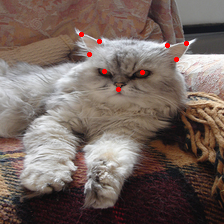

In [15]:
img2, kps2 = scale_img_kps(img, kps, target_size=224)
display(draw_keypoints(img2.copy(), kps2))

Helper to load and transform both input image and keypoints

In [16]:
def load_image_keypoints(image_path, keypoints_path, target_size):
    image = PIL.Image.open(image_path)
    keypoints = load_keypoints(keypoints_path)
    image_new, keypoints_new = scale_img_kps(image, keypoints, target_size)
    return image, keypoints, image_new, keypoints_new

Show couple more examples

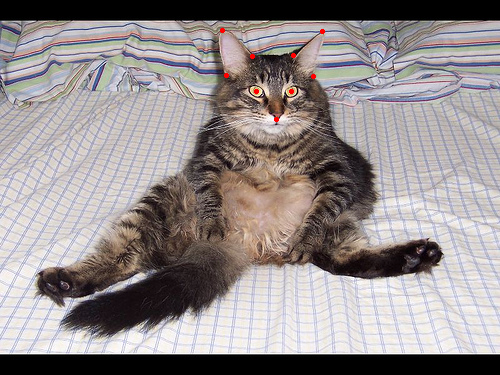

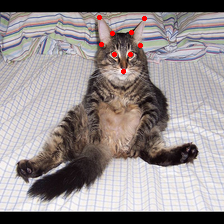

In [17]:
idx = 21

image, keypoints, image_new, keypoints_new = load_image_keypoints(
    image_paths_all[idx], image_paths_all[idx]+'.cat', target_size=224)
display(draw_keypoints(image.copy(), keypoints))
display(draw_keypoints(image_new.copy(), keypoints_new))

**Custom Generator**

In [18]:
class CatSequence(tf.keras.utils.Sequence):

    def __init__(self, files_list, target_size, batch_size,
                 preprocess_images_function=None,
                 preprocess_keypts_function=None,
                 shuffle=False):
        """Custom data generator to use with model.fit_generator()
        
        Params:
            file_list - list with file paths
            target_size - target image size as integer (output img is square)
            batch_size - mini-batch size
            shuffle - shuffle features/targets between epochs
            preprocess_images_function - 
                function to be called on images mini batch,
                e.g. tf.keras.application.resnet50.preprocess_input
            preprocess_keypts_function - same as above but for keypoints
        
        Note:
            this class 'shuffle' param will shuffle all examples between epochs
            model.fit_generator(shuffle=...) param shufles order of mini-batches,
                but does not touch what is inside mini-batch
        """
        assert isinstance(files_list, (list, tuple, np.ndarray))
        assert isinstance(target_size, int) and target_size > 0
        assert isinstance(batch_size, int) and batch_size > 0
        assert preprocess_images_function is None or callable(preprocess_images_function)
        assert preprocess_keypts_function is None or callable(preprocess_keypts_function)
        assert isinstance(shuffle, bool)
        
        self.files_list = np.array(files_list)  # for advanced indexing
        self.target_size = target_size
        self.batch_size = batch_size
        self.preprocess_images_function = preprocess_images_function
        self.preprocess_keypts_function = preprocess_keypts_function
        self.shuffle = shuffle
        self.on_epoch_end()
        

    def __len__(self):
        return int(np.ceil(len(self.files_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_i = self.indices[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_fl = self.files_list[batch_i]
        
        images_list, keypoints_list = [], []
        for file_path in batch_fl:
            _, _, image_new, keypoints_new = load_image_keypoints(
                file_path, file_path+'.cat', target_size=self.target_size)
            image_arr = np.array(image_new)
            images_list.append(image_arr)
            keypoints_list.append(keypoints_new)
        
        images_arr = np.array(images_list)
        keypoints_arr = np.array(keypoints_list)
        
        if self.preprocess_images_function is not None:
            images_arr = self.preprocess_images_function(images_arr)
        if self.preprocess_keypts_function is not None:
            keypoints_arr = self.preprocess_keypts_function(keypoints_arr)
        
        return images_arr, keypoints_arr

    def on_epoch_end(self):
        self.indices = np.arange(len(self.files_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

Split into train and validation sets

In [19]:
split = 8000
train_files = image_paths_all[:split]
valid_files = image_paths_all[split:]

Create generators

* images are normalised in the same way as dataset used for network pretraining (ImageNet)
* keypoints are normalised to range roughly -1..1

In [20]:
train_generator = CatSequence(train_files, batch_size=32, target_size=224,
    preprocess_images_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    preprocess_keypts_function=lambda keypoints : (keypoints-112) / 112)
valid_generator = CatSequence(valid_files, batch_size=32, target_size=224,
    preprocess_images_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    preprocess_keypts_function=lambda keypoints : (keypoints-112) / 112)

Functions to reverse normalisation, so we can plot images

**Note:** _undo_preprocess_images_ is **not** exact reverse of image normalisation, hence images colour space looks a bit strange. This is ok for our purposes.

In [21]:
def undo_preprocess_images(images_batch):
    tmp = images_batch
    tmp = (tmp + tmp.min()) / (tmp.max() - tmp.min())
    tmp = (tmp * 255).astype(np.uint8)
    return tmp

In [22]:
def undo_preprocess_keypts(keypoints_batch, img_size):
    return (keypoints_batch * (img_size // 2)) + (img_size // 2) 

Show couple samples

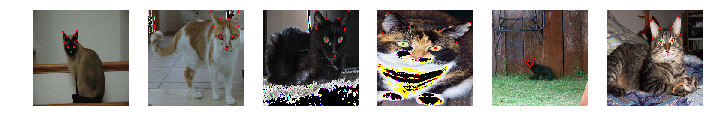

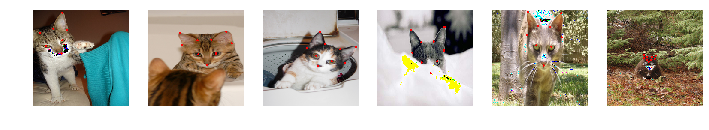

In [23]:
train_images, train_keypoints = train_generator[0]
plot_images([5, 10, 15, 20, 25, 30],
            undo_preprocess_images(train_images),
            undo_preprocess_keypts(train_keypoints, img_size=224))

valid_images, valid_keypoints = valid_generator[0]
plot_images([5, 10, 15, 20, 25, 30],
            undo_preprocess_images(valid_images),
            undo_preprocess_keypts(valid_keypoints, img_size=224))

# Train End-to-End

Define model

In [24]:
X_inputs = tf.keras.layers.Input(shape=(224, 224, 3))

mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False,
    weights='imagenet', input_tensor=X_inputs, pooling='max')

X = tf.keras.layers.Dense(128, activation='relu')(mobilenetv2.layers[-1].output)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(18, activation='linear')(X)
X = tf.keras.layers.Reshape((9, 2))(X)

model = tf.keras.models.Model(inputs=X_inputs, outputs=X)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Custom callback for plotting

In [29]:
class CallbackPlot(tf.keras.callbacks.Callback):
    def __init__(self, train_images, valid_images):
        self.train_images = train_images
        self.valid_images = valid_images
    
    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, batch, logs={}):
        _, iw, ih, _ = self.train_images.shape
        
        predictions = model.predict(self.train_images)
        plot_images([5, 10, 15, 20, 25, 30],
                    undo_preprocess_images(self.train_images),
                    undo_preprocess_keypts(predictions, iw))
        
        predictions = model.predict(self.valid_images)
        plot_images([5, 10, 15, 20, 25, 30],
                    undo_preprocess_images(self.valid_images),
                    undo_preprocess_keypts(predictions, iw))

Show some cats before training. Most probably there won't be any keypoints shown

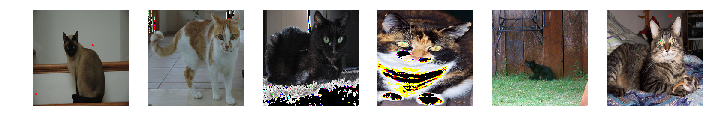

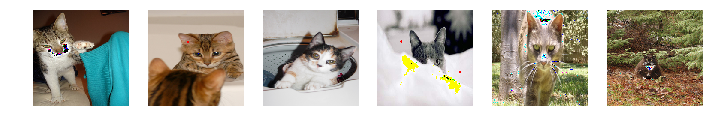

In [30]:
callback_plt = CallbackPlot(train_images, valid_images)
callback_plt.on_epoch_end(None)

In [31]:
#
#   Callbacks
#

# tb_logdir = os.path.expanduser('~/logs/')
# tb_counter  = len([log for log in os.listdir(tb_logdir) if 'cats' in log]) + 1
# callback_tb = tf.keras.callbacks.TensorBoard(
#     log_dir=tb_logdir + 'cats' + '_' + str(tb_counter), )

callback_mc = tf.keras.callbacks.ModelCheckpoint(
    'model.h5', save_best_only=True, verbose=1)

callback_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=1)

callback_plt = CallbackPlot(train_images, valid_images)

#
#   Train
#
hist = model.fit_generator(train_generator, epochs=50, shuffle=True,
  validation_data=valid_generator,
  callbacks=[
             #callback_tb,     # uncomment to log into TensorBoard
             callback_mc,
             callback_lr,
             #callback_plt,    # uncomment this to enable plotting during training
            ]
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
63/63 [==============================] - 29s 457ms/step - loss: 2.0777

Epoch 00001: val_loss improved from inf to 2.07768, saving model to model.h5
250/250 [==============================] - 180s 721ms/step - loss: 0.2117 - val_loss: 2.0777
Epoch 2/50
63/63 [==============================] - 25s 390ms/step - loss: 0.7707

Epoch 00002: val_loss improved from 2.07768 to 0.77072, saving model to model.h5
250/250 [==============================] - 138s 553ms/step - loss: 0.0450 - val_loss: 0.7707
Epoch 3/50
63/63 [==============================] - 24s 386ms/step - loss: 0.2596

Epoch 00003: val_loss improved from 0.77072 to 0.25960, saving model to model.h5
250/250 [==============================] - 135s 539ms/step - loss: 0.0238 - val_loss: 0.2596
Epoch 4/50
63/63 [==============================] - 24s 388ms/step - loss: 0.0995

Epoch 00004: val_loss im

The final train loss should be around _0.0020_ and final validation loss around _0.0060_

Plot loss during training

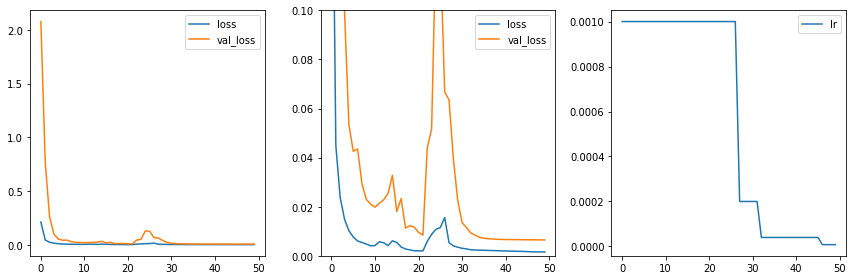

In [32]:
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax1.plot(hist.history['loss'], label='loss')
ax1.plot(hist.history['val_loss'], label='val_loss')
ax1.legend()

ax2.plot(hist.history['loss'], label='loss')
ax2.plot(hist.history['val_loss'], label='val_loss')
ax2.legend()
ax2.set_ylim(0, .1)

ax3.plot(hist.history['lr'], label='lr')
ax3.legend()

plt.tight_layout()
plt.show()

Show some cats from validation set - looks pretty good

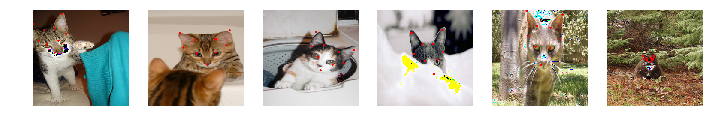

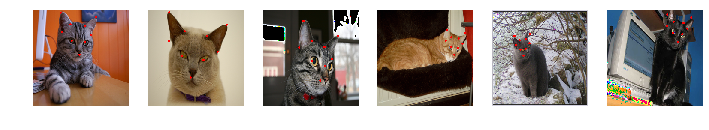

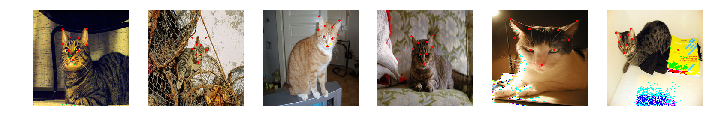

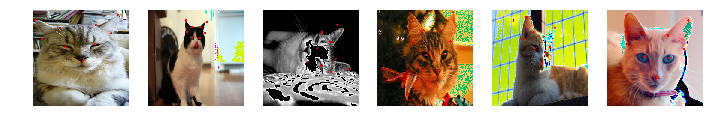

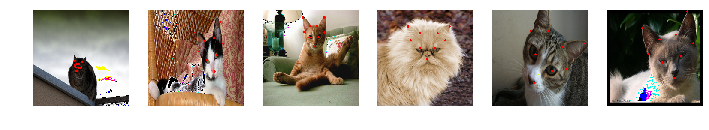

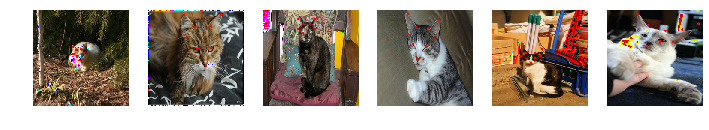

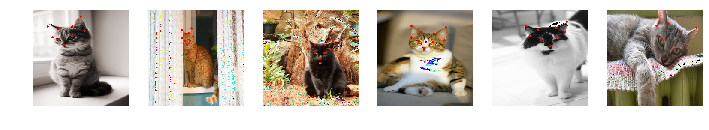

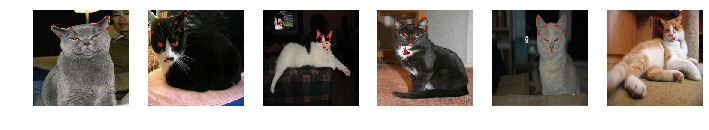

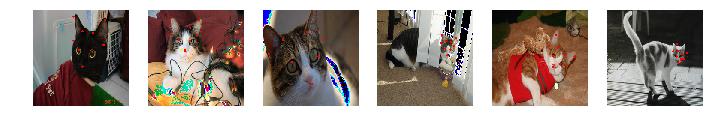

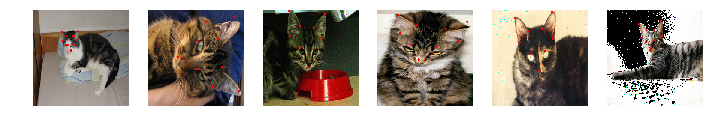

In [39]:
for i in range(10):
    valid_images, _ = valid_generator[i]
    predictions = model.predict(valid_images)
    plot_images([5, 10, 15, 20, 25, 30],
                undo_preprocess_images(valid_images),
                undo_preprocess_keypts(predictions, img_size=224))